# Medium_range National Water Model Forecast
### Workflow for creating a 10-day streamflow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [1]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import json

import dask 
from dask.distributed import Client, LocalCluster
# import dask.bag as db
from multiprocessing import cpu_count

%matplotlib inline

## Start the local cluster
#### *__NOTE__*: this is *currently* equal or slower in computation time because of the overhead of the dask scheduler. Without the local cluster, xarray operates serially.

In [5]:
num_workers = cpu_count()
cluster = LocalCluster(n_workers=num_workers)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:50573 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.21 GB


## Set up the Google Cloud File System

In [6]:
fs = gcsfs.GCSFileSystem(project='national-water-model')
# alldays = fs.ls('national-water-model')
# len(alldays)

## Open all netcdf files of interest, concat them into an xarray multifile dataset

- This step takes longer than expected due to reading from GCS over the internet

In [8]:
date = '20190730' # todays date
start_time = '00' # start at 00:00 
mem = '1' # medium range mem number
open_ncdfs = []
for i in range(3,241, 3): # for times 3-240 in steps of 3
    hr = str(i).zfill(3)
    filepath = f'national-water-model/nwm.{date}/medium_range_mem{mem}/nwm.t{start_time}z.medium_range.channel_rt_{mem}.f{hr}.conus.nc'
    file = fs.open(filepath, 'rb')
    open_ncdfs.append(file)
mfdset = xr.open_mfdataset(open_ncdfs)
mfdset

<xarray.Dataset>
Dimensions:         (feature_id: 2729077, reference_time: 1, time: 80)
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 2019-07-30
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
  * time            (time) datetime64[ns] 2019-07-30T03:00:00 ... 2019-08-09
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    streamflow      (time, feature_id) float64 dask.array<shape=(80, 2729077), chunksize=(1, 2729077)>
    nudge           (time, feature_id) float64 dask.array<shape=(80, 2729077), chunksize=(1, 2729077)>
    velocity        (time, feature_id) float64 dask.array<shape=(80, 2729077), chunksize=(1, 2729077)>
Attributes:
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2019-07-30_00:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2019-07-30_03:0

## Get only the streamflow data for the COMID of interest

In [9]:
comid = 4512772
output_da = mfdset.sel(feature_id=comid)['streamflow']
output_da

<xarray.DataArray 'streamflow' (time: 80)>
dask.array<shape=(80,), dtype=float64, chunksize=(1,)>
Coordinates:
    feature_id  int32 4512772
  * time        (time) datetime64[ns] 2019-07-30T03:00:00 ... 2019-08-09
Attributes:
    long_name:     River Flow
    units:         m3 s-1
    coordinates:   latitude longitude
    grid_mapping:  crs
    valid_range:   [      0 5000000]

# What is the desired output JSON format?

In [10]:
test_output = {'COMID': comid, 'data': dict(zip(output_da['time'].values.astype(str), output_da.values))}
print(json.dumps(test_output, sort_keys=True, indent=4))

{
    "COMID": 4512772,
    "data": {
        "2019-07-30T03:00:00.000000000": 171.6599961631,
        "2019-07-30T06:00:00.000000000": 184.9199958667159,
        "2019-07-30T09:00:00.000000000": 186.59999582916498,
        "2019-07-30T12:00:00.000000000": 184.48999587632716,
        "2019-07-30T15:00:00.000000000": 181.62999594025314,
        "2019-07-30T18:00:00.000000000": 178.76999600417912,
        "2019-07-30T21:00:00.000000000": 175.98999606631696,
        "2019-07-31T00:00:00.000000000": 173.27999612689018,
        "2019-07-31T03:00:00.000000000": 170.6899961847812,
        "2019-07-31T06:00:00.000000000": 168.24999623931944,
        "2019-07-31T09:00:00.000000000": 166.0899962875992,
        "2019-07-31T12:00:00.000000000": 164.27999632805586,
        "2019-07-31T15:00:00.000000000": 162.8799963593483,
        "2019-07-31T18:00:00.000000000": 161.899996381253,
        "2019-07-31T21:00:00.000000000": 161.27999639511108,
        "2019-08-01T00:00:00.000000000": 160.939996402710

In [11]:
print(json.dumps(output_da.to_dict(), indent=4, default=str))

{
    "dims": [
        "time"
    ],
    "attrs": {
        "long_name": "River Flow",
        "units": "m3 s-1",
        "coordinates": "latitude longitude",
        "grid_mapping": "crs",
        "valid_range": [
            0,
            5000000
        ]
    },
    "data": [
        171.6599961631,
        184.9199958667159,
        186.59999582916498,
        184.48999587632716,
        181.62999594025314,
        178.76999600417912,
        175.98999606631696,
        173.27999612689018,
        170.6899961847812,
        168.24999623931944,
        166.0899962875992,
        164.27999632805586,
        162.8799963593483,
        161.899996381253,
        161.27999639511108,
        160.93999640271068,
        160.78999640606344,
        160.759996406734,
        160.64999640919268,
        160.5299964118749,
        160.33999641612172,
        160.08999642170966,
        159.81999642774463,
        159.58999643288553,
        159.47999643534422,
        159.56999643333256,
   

# Plot it and compare to a plot grabbed from the Hydroshare NWM forecast Viewer

In [12]:
# get an array of the streamflow values in cms
output_arr = output_da.values
output_arr

array([171.65999616, 184.91999587, 186.59999583, 184.48999588,
       181.62999594, 178.769996  , 175.98999607, 173.27999613,
       170.68999618, 168.24999624, 166.08999629, 164.27999633,
       162.87999636, 161.89999638, 161.2799964 , 160.9399964 ,
       160.78999641, 160.75999641, 160.64999641, 160.52999641,
       160.33999642, 160.08999642, 159.81999643, 159.58999643,
       159.47999644, 159.56999643, 159.92999643, 160.59999641,
       161.57999639, 162.86999636, 164.35999633, 166.81999627,
       168.49999623, 170.0699962 , 172.51999614, 175.81999607,
       178.52999601, 179.139996  , 178.09999602, 176.28999606,
       174.15999611, 171.95999616, 169.75999621, 167.59999625,
       165.4999963 , 163.44999635, 161.44999639, 159.50999643,
       157.64999648, 155.87999652, 154.22999655, 152.69999659,
       151.26999662, 149.91999665, 148.62999668, 147.38999671,
       146.15999673, 144.94999676, 143.74999679, 142.56999681,
       141.41999684, 140.33999686, 139.53999688, 138.48

In [11]:
# cms_to_cfs_factor = 35.31467
# cfsout = output_arr*cms_to_cfs_factor

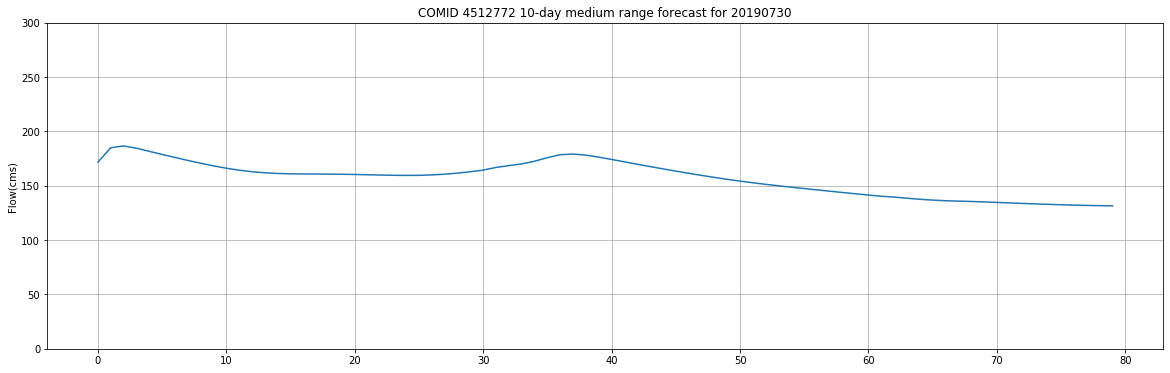

In [14]:
# plot it
fig, ax = plt.subplots(figsize=(20, 6))
ax.grid(True, which="both")
ax.plot(output_arr)
ax.set_ylabel('Flow(cms)')
# ax.set_xlabel('Hours from start time in multiples of three?')

ax.set_title(f'COMID {comid} 10-day medium range forecast for {date}')
ax.set_autoscaley_on(False)
ax.set_ylim([0,300])

plt.show()

In [19]:
[f.close() for f in open_ncdfs];